In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [93]:
# Funzione per generare prezzi casuali secondo una distribuzione di probabilità
def generate_prices(distribution, N):
    prices = [100]  # Prezzo iniziale
    for _ in range(1, N):
        change = np.random.choice(list(distribution.keys()), p=list(distribution.values()))
        new_price = prices[-1] * change
        prices.append(new_price)
    return prices

# def max_decimal_places(distribution):
#     max_decimals = 0
#     for key in distribution.keys():
#         # Converte il numero in una stringa e conta i decimali (dopo il punto decimale)
#         decimals = str(key)[::-1].find('.')
#         if decimals != -1:
#             max_decimals = max(max_decimals, decimals)
#     return max_decimals

def multinomial_probability(distribution, counts_temp):
    # Calcoliamo N, il numero totale di variazioni di prezzo osservate
    N = sum(counts_temp.values())
    
    # Calcoliamo il fattoriale di N
    N_factorial = math.factorial(N)
    
    # Calcoliamo il denominatore (prodotto dei fattoriali dei conteggi) 
    # e il prodotto delle probabilità elevate ai conteggi
    denominator = 1
    probability_product = 1.0
    
    for variation, count in counts_temp.items():
        denominator *= math.factorial(count)
        probability_product *= distribution[variation] ** count
    
    # Calcoliamo la probabilità utilizzando la formula del multinomiale
    probability = N_factorial / denominator * probability_product
    
    return probability

def calculate_probabilities_personal(prices, distribution):
    # Contiamo quante volte si è verificato ogni cambiamento di prezzo
    counts = {change: 0 for change in distribution.keys()}
    
    for i in range(1, len(prices)):
        # price_change = prices[i] / prices[i-1]
        # Trovare il cambio più vicino in distribuzione
        for change in distribution.keys():
            # if abs(price_change - change) < tolerance:
            if change*prices[i-1] == prices[i]:
                counts[change] += 1
                break
    
    # Calcoliamo le probabilità a posteriori utilizzando l'approccio bayesiano
    updated_distribution = {}
    
    for change in distribution.keys():
        counts_temp = counts.copy()
        # if abs(price_change - change) < tolerance:
        counts_temp[change] += 1
        # Ora mi chiedo a posteriori qual era la probabilità che la lista dei prezzi diventasse questa
        updated_distribution[change] = multinomial_probability(distribution, counts_temp)

    return updated_distribution
    

def simulate_trading(prices, distribution):
    capital = 1000  # Capitale iniziale
    tokens = 0  # Token iniziali
    portfolio_values = [capital]  # Valore del portafoglio nel tempo
    transactions = []

    for i in range(1, len(prices)):
        for change in distribution.keys():
                if change*prices[i-1] == prices[i]:
                    change_happened = change
        # Calcoliamo la distribuzione aggiornata per il giorno successivo
        updated_distribution = calculate_probabilities_personal(prices[:i+1], distribution)
        
        # Normalizziamo updated_distribution
        total_prob = sum(updated_distribution.values())
        updated_distribution_normalized = {k: v / total_prob for k, v in updated_distribution.items()}
        
        # Troviamo la chiave con la probabilità massima
        max_key = max(updated_distribution_normalized, key=updated_distribution_normalized.get)
        
        # Calcoliamo i valori attesi
        # expected_values = {k: updated_distribution_normalized[k] * k for k in updated_distribution.keys()}
        
        # Normalizziamo i valori attesi
        # total_expected_value = sum(expected_values.values())
        # expected_values_normalized = {k: v / total_expected_value for k, v in expected_values.items()}

        print('updated_distribution:', updated_distribution)
        print('updated_distribution_normalized:', updated_distribution_normalized)
        print('max_key:', max_key)
        # print('expected_values:', expected_values)
        # print('expected_values_normalized:', expected_values_normalized)
        print('\n')
        
        
        # Decidiamo se comprare o vendere
        if max_key > 1:
            # Comprare
            amount_to_spend = capital * updated_distribution_normalized[max_key]
            tokens_bought = amount_to_spend / prices[i]
            previous_capital = capital
            capital -= amount_to_spend
            tokens += tokens_bought
            if amount_to_spend > 0:
                transactions.append((i, capital, tokens, prices[i], change_happened, 'Acquisto', amount_to_spend, amount_to_spend/previous_capital, tokens*prices[i] + capital, max_key, updated_distribution_normalized[max_key]))
            else:
                transactions.append((i, capital, tokens, prices[i], change_happened, '-', 0, 0, tokens*prices[i] + capital, max_key, updated_distribution_normalized[max_key]))
        else:
            # Vendere
            tokens_to_sell = tokens * updated_distribution_normalized[max_key]
            amount_gained = tokens_to_sell * prices[i]
            previous_tokens = tokens
            tokens -= tokens_to_sell
            capital += amount_gained
            if tokens_to_sell > 0:
                transactions.append((i, capital, tokens, prices[i], change_happened, 'Vendita', amount_gained, tokens_to_sell/previous_tokens, tokens*prices[i] + capital, max_key, updated_distribution_normalized[max_key]))
            else:
                transactions.append((i, capital, tokens, prices[i], change_happened, '-', 0, 0, tokens*prices[i] + capital, max_key, updated_distribution_normalized[max_key]))
        
        # Calcoliamo il valore del portafoglio
        portfolio_value = capital + tokens * prices[i]
        portfolio_values.append(portfolio_value)
    
    return portfolio_values, transactions

updated_distribution: {0.01: 0.03, 0.3: 0.06, 0.5: 0.06, 0.9: 0.09, 1.1: 0.15, 1.5: 0.054, 2: 0.06, 200: 0.006}
updated_distribution_normalized: {0.01: 0.058823529411764705, 0.3: 0.11764705882352941, 0.5: 0.11764705882352941, 0.9: 0.1764705882352941, 1.1: 0.29411764705882354, 1.5: 0.10588235294117647, 2: 0.11764705882352941, 200: 0.011764705882352941}
max_key: 1.1


updated_distribution: {0.01: 0.0081, 0.3: 0.0162, 0.5: 0.0162, 0.9: 0.0243, 1.1: 0.0405, 1.5: 0.00729, 2: 0.0162, 200: 0.00162}
updated_distribution_normalized: {0.01: 0.06211180124223601, 0.3: 0.12422360248447202, 0.5: 0.12422360248447202, 0.9: 0.18633540372670804, 1.1: 0.3105590062111801, 1.5: 0.05590062111801241, 2: 0.12422360248447202, 200: 0.012422360248447202}
max_key: 1.1


updated_distribution: {0.01: 0.0032400000000000007, 0.3: 0.0032400000000000007, 0.5: 0.006480000000000001, 0.9: 0.00972, 1.1: 0.0162, 1.5: 0.0029159999999999998, 2: 0.00648, 200: 0.0006479999999999999}
updated_distribution_normalized: {0.01: 0.066

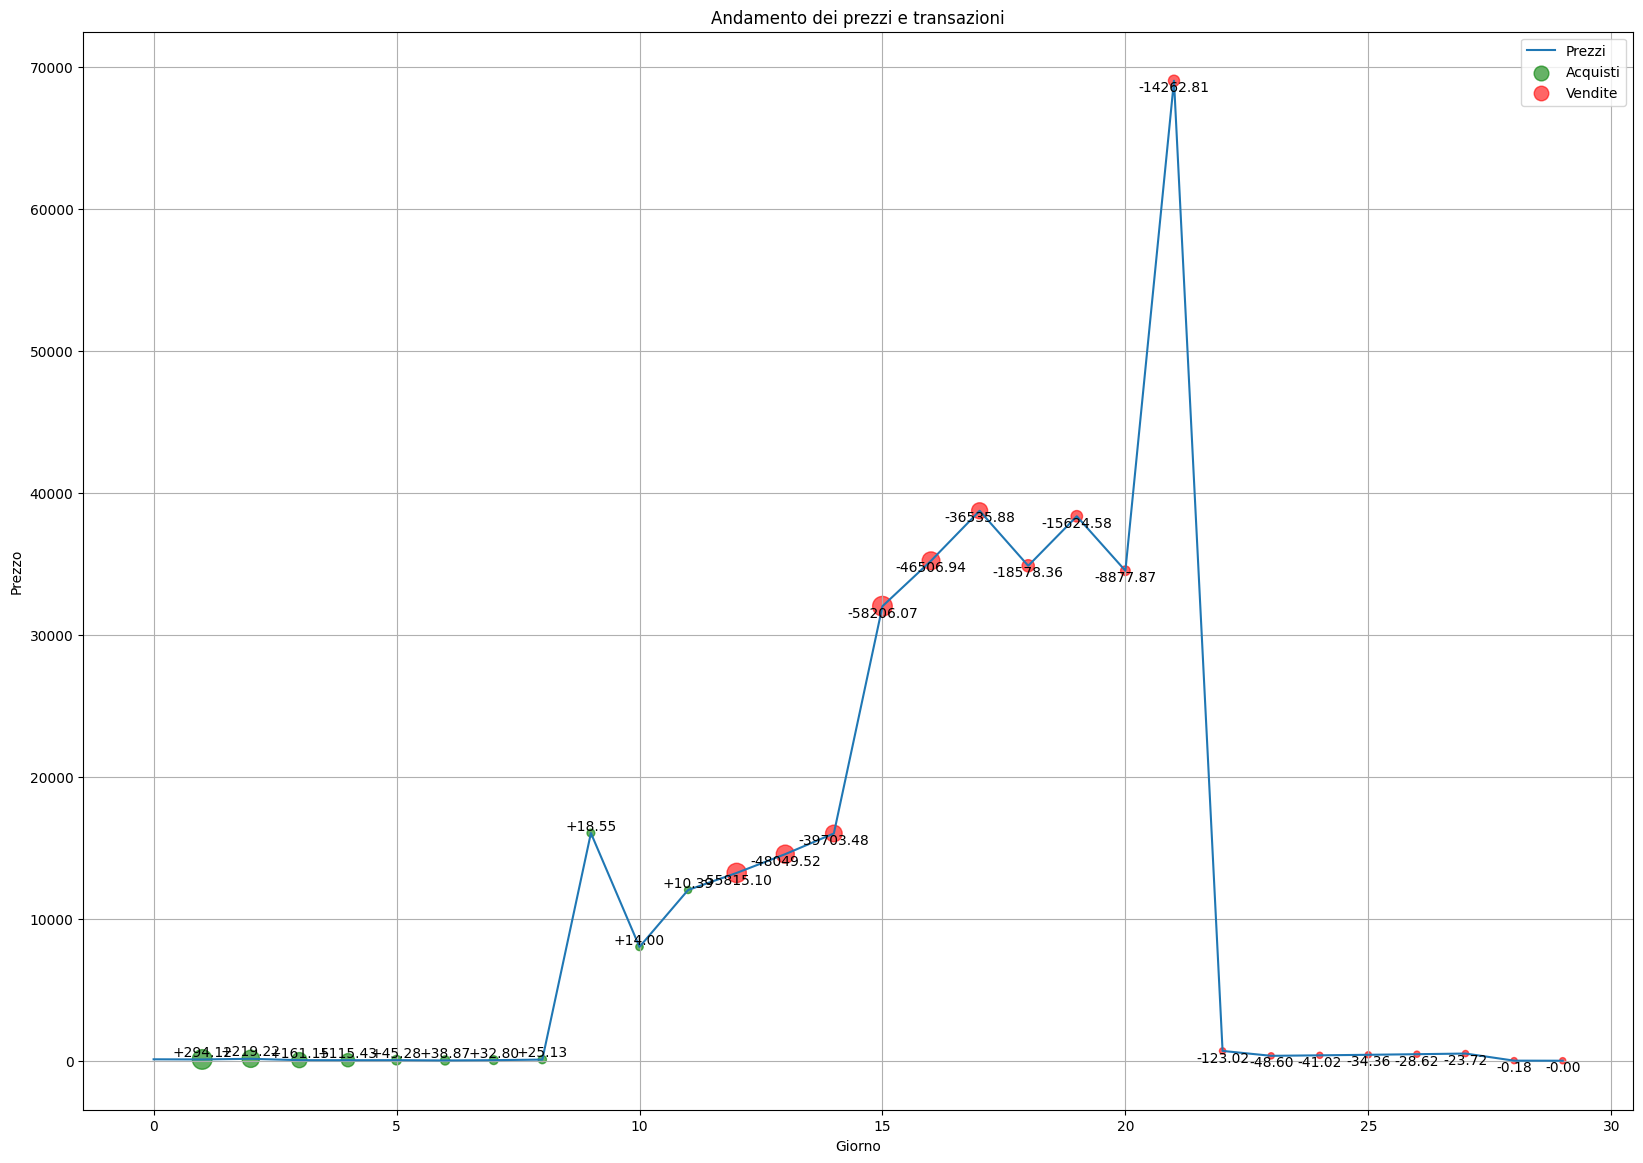

Rendimento totale del portafoglio: 342.49


,Giorno,Liquidità posseduta (€),Token posseduti,Prezzo (€),Variazione avvenuta,Tipo,Quantità (€),% comprata/venduta,Portafoglio totale (€),Variazione più probabile,Probabilità normalizzata della variazione più probabile
0,1,705.882353,3.267974,90.000000,0.90,Acquisto,294.117647,0.294118,1000.000000,1.1,0.294118
1,2,486.664231,4.891812,135.000000,1.50,Acquisto,219.218122,0.310559,1147.058824,1.1,0.310559
2,3,325.517135,8.870752,40.500000,0.30,Acquisto,161.147096,0.331126,684.782609,1.1,0.331126
3,4,210.085527,12.037600,36.450000,0.90,Acquisto,115.431608,0.354610,648.856061,1.1,0.354610
4,5,164.808473,13.166845,40.095000,1.10,Acquisto,45.277053,0.215517,692.733115,1.1,0.215517
5,6,125.938550,15.105736,20.047500,0.50,Acquisto,38.869923,0.235849,428.770794,1.1,0.235849
6,7,93.142053,15.923706,40.095000,2.00,Acquisto,32.796498,0.260417,731.603038,1.1,0.260417
7,8,68.013801,16.237065,80.190000,2.00,Acquisto,25.128252,0.269784,1370.064023,1.1,0.269784
8,9,49.464583,16.238221,16038.000000,200.00,Acquisto,18.549219,0.272727,260478.058058,1.1,0.272727
9,10,35.465173,16.239967,8019.000000,0.50,Acquisto,13.999410,0.283019,130263.761320,1.1,0.283019


In [95]:
# Configurazione della distribuzione e del numero di giorni
distribution = {0.01: 0.05, 0.3: 0.1, 0.5: 0.1, 0.9: 0.3, 1.1: 0.25, 1.5: 0.09, 2: 0.1, 200: 0.01}
N = 30 # Numero di giorni

# Generazione dei prezzi e simulazione
prices = generate_prices(distribution, N)
portfolio_values, transactions = simulate_trading(prices, distribution)

# Preparazione dei dati per il grafico
columns = ['Giorno', 'Liquidità posseduta (€)', 'Token posseduti', 'Prezzo (€)', 'Variazione avvenuta', 'Tipo', 'Quantità (€)', '% comprata/venduta', 'Portafoglio totale (€)', 'Variazione più probabile', 'Probabilità normalizzata della variazione più probabile']
df_transazioni = pd.DataFrame(transactions, columns=columns)

# Filtrare acquisti e vendite
acquisti = df_transazioni[df_transazioni['Tipo'] == 'Acquisto']
vendite = df_transazioni[df_transazioni['Tipo'] == 'Vendita']

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['Quantità (€)'].max() if not acquisti.empty else 0
max_vendita = vendite['Quantità (€)'].max() if not vendite.empty else 0

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita > 0 else min_size

dimensioni_acquisti = [calcola_dimensione(x, max_acquisto) for x in acquisti['Quantità (€)']] if not acquisti.empty else []
dimensioni_vendite = [calcola_dimensione(x, max_vendita) for x in vendite['Quantità (€)']] if not vendite.empty else []

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(range(N), prices, label='Prezzi')

if not acquisti.empty:
    plt.scatter(acquisti['Giorno'], acquisti['Prezzo (€)'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    for i, row in acquisti.iterrows():
        plt.text(row['Giorno'], row['Prezzo (€)'], f"+{row['Quantità (€)']:.2f}", color='black', ha='center', va='bottom')

if not vendite.empty:
    plt.scatter(vendite['Giorno'], vendite['Prezzo (€)'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    for i, row in vendite.iterrows():
        plt.text(row['Giorno'], row['Prezzo (€)'], f"-{row['Quantità (€)']:.2f}", color='black', ha='center', va='top')

plt.xlabel('Giorno')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

# Mostra il rendimento totale del portafoglio
print(f"Rendimento totale del portafoglio: {portfolio_values[-1] / portfolio_values[0]:.2f}")

# Stampa del dataframe delle transazioni
df_transazioni

In [38]:
expected_values = {6:0.5*6, 400:0.01*400, 10:0.49*10}
        
# Troviamo la chiave con il valore atteso massimo
max_expected_value_key = max(expected_values, key=expected_values.get)
max_expected_value = expected_values[max_expected_value_key]
max_expected_value

4.9

In [15]:
calculate_probabilities_personal(prices, distribution)

{0.5: 0.205078125, 2: 0.24609375}

In [31]:
distribution = {0.5: 0.9, 2: 0.1}
prices = [100, 50, 25, 12.5, 6.25] # generate_prices(distribution, 2)
print(prices)
calculate_probabilities_personal(prices, distribution)

[100, 50, 25, 12.5, 6.25]


{0.5: 0.5904900000000001, 2: 0.32805}

In [28]:
# Esempio di utilizzo:
distribution = {
    0.3: 0.70,
    1.2: 0.20,
    4.0: 0.10
}

counts_temp = {
    0.3: 4,
    1.2: 3,
    4.0: 3
}

result = multinomial_probability(distribution, counts_temp)
print(f"La probabilità della serie storica di variazioni di prezzo è: {result}")

La probabilità della serie storica di variazioni di prezzo è: 0.008067360000000003
